In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from itertools import product
from tqdm import tqdm

from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

In [3]:
matplotlib.rcParams['pcolor.shading'] = 'auto'

## Study of MEn(2) order

As in paper [1], we will study the performance on the $(c-1/c, \gamma)$ plane, where $c$ is a coefficient of variation.

Note that equation $c - 1/c = x$ always have a single solution for $c > 0$:

$$
c - 1/c = x \; \Leftrightarrow \; c^2 - xc - 1 = 0 \Leftrightarrow c = \frac{x + \sqrt{x^2 + 4}}{2}
$$

In [4]:
def x2cv(x: float) -> float:
    """Get CV value from c-1/c value.
    """
    return (x + pow(x**2 + 4, 0.5)) / 2

In [5]:
GRID_SIZE = 100
X = np.linspace(-10, 10, GRID_SIZE)  # c - 1/c values
Y = np.linspace(-10, 10, GRID_SIZE)  # gamma (skewness) values, not all feasible
CV = np.asarray([x2cv(x) for x in X])
PLANE_SHAPE = (GRID_SIZE, GRID_SIZE)
COORDS = list(product(range(GRID_SIZE), range(GRID_SIZE)))
MEAN = 1.0

In [6]:
raw_dists = [[
    fit_mern2([MEAN, get_noncentral_m2(MEAN, cv), get_noncentral_m3(MEAN, cv, y)])[0]
    if y > x else None for (x, cv) in zip(X, CV)
] for y in tqdm(Y)]

100%|██████████| 100/100 [00:00<00:00, 267.52it/s]


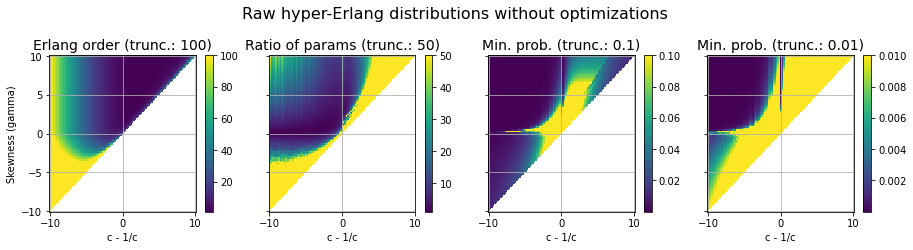

In [7]:
def plot_dist_params(distributions, title="", y_size=5):
    orders = np.zeros(shape=PLANE_SHAPE)
    min_p_1 = np.zeros(shape=PLANE_SHAPE)
    min_p_2 = np.zeros(shape=PLANE_SHAPE)
    max_ratio = np.zeros(shape=PLANE_SHAPE)
    for (i, j) in COORDS:
        dist = distributions[i][j]
        if dist is None:
            orders[i][j] = np.nan
            min_p_1[i][j] = np.nan
            min_p_2[i][j] = np.nan
            max_ratio[i][j] = np.nan
            continue
        assert isinstance(dist, HyperErlang)
        params = dist.params
        orders[i][j] = min(dist.order/2, 100)
        min_p_1[i][j] = min(min([p for p in dist.probs if p > 0]), 0.1)
        min_p_2[i][j] = min(min([p for p in dist.probs if p > 0]), 0.01)
        max_ratio[i][j] = min(max(params) / min(params), 50)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, y_size), ncols=4, nrows=1, sharey=True)
    im1 = ax1.pcolormesh(X, Y, orders)
    im2 = ax2.pcolormesh(X, Y, max_ratio)
    im3 = ax3.pcolormesh(X, Y, min_p_1)
    im4 = ax4.pcolormesh(X, Y, min_p_2)
    fig.suptitle(title, fontsize=16) 
    ax1.set_title('Erlang order (trunc.: 100)', fontsize=14)
    ax2.set_title('Ratio of params (trunc.: 50)', fontsize=14)
    ax3.set_title('Min. prob. (trunc.: 0.1)', fontsize=14)
    ax4.set_title('Min. prob. (trunc.: 0.01)', fontsize=14)
    ax1.set_ylabel('Skewness (gamma)')
    for im, ax in zip((im1, im2, im3, im4), (ax1, ax2, ax3, ax4)):
        fig.colorbar(im, ax=ax)
        ax.set_xlabel('c - 1/c')
        ax.grid()
    plt.tight_layout()    

#
# Plot original hyper-Erlang distributions without optimizations of ratios or probabilities.
#
plot_dist_params(raw_dists, "Raw hyper-Erlang distributions without optimizations", y_size=3.5)

In [15]:
MAX_INC = [2, 5, 10, 20, 30]
opt_ratio_dists = [[[
    fit_mern2([MEAN, get_noncentral_m2(MEAN, cv), get_noncentral_m3(MEAN, cv, y)], max_shape_inc=inc)[0]
    if y > x else None for (x, cv) in zip(X, CV)
] for y in Y] for inc in tqdm(MAX_INC)]

100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


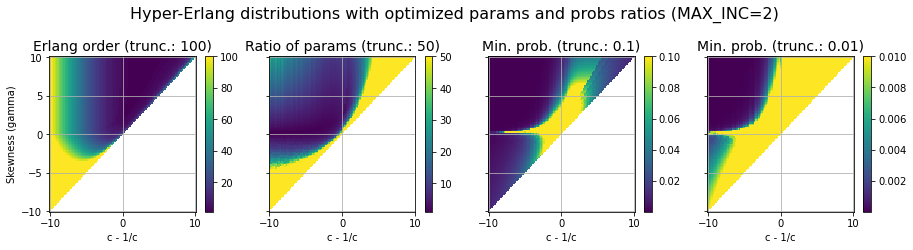

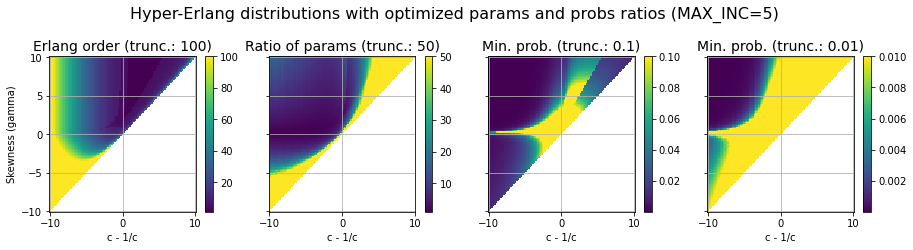

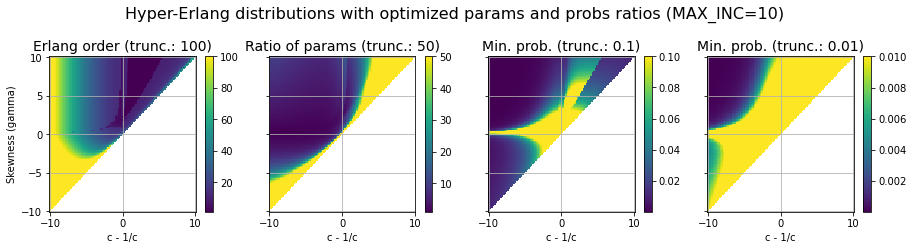

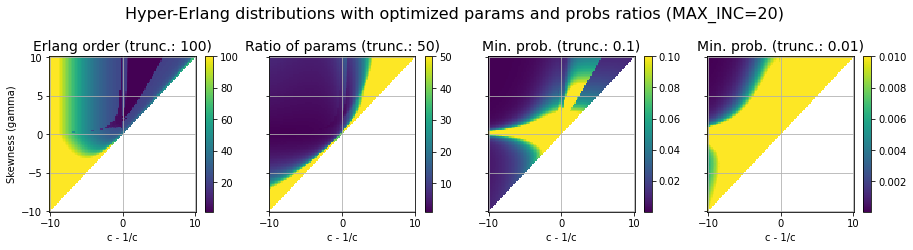

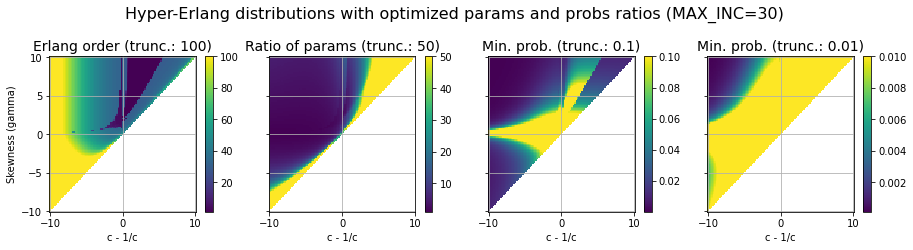

In [16]:
for i, inc in enumerate(MAX_INC):
    plot_dist_params(opt_ratio_dists[i], f"Hyper-Erlang distributions with optimized params and probs ratios (MAX_INC={inc})",
                     y_size=3.5)